In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import scanpy as sc
from cv2 import resize
from tqdm.notebook import tqdm
import json

Roll 1 of Beta8 was the reference in the MERSCOPE data. Hardcoded in here.

We first convert the MERSCOPE micron coordinates to pixels.

In [41]:
merscope_path = r'/projects/2023_Spatial_Paper/Analysis_Alex/merscope_final/SI-Ctrl-L-RAR-R-dist-1-VS120-NP_Beta8'
reference_unrolled = sc.read(os.path.join(merscope_path, 'adatas', '05_reference_unrolled.h5ad'))

vill_seg = np.load(os.path.join(merscope_path, 'villi_segmentation_mask.npy'))
adata = sc.read(os.path.join(merscope_path, 'adatas', '06_before_decomposition_model_roll1.h5ad'))


In [42]:
adata.obs['x'] = adata.obsm['X_spatial'][:, 0]
adata.obs['y'] = adata.obsm['X_spatial'][:, 1]

In [66]:
def apply_transform(point, matrix):
    x, y, _ = point
    new_x = matrix[0][0] * x + matrix[0][1] * y + matrix[0][2]
    new_y = matrix[1][0] * x + matrix[1][1] * y + matrix[1][2]
    return new_x, new_y


xvals = adata.obs.x.values
yvals = adata.obs.y.values

points = [(xvals[j], yvals[j], 1) for j in range(len(xvals))]

# The matrix in the micron_to_mosaic file supplied in the reference output by Vizgen.
matrix = [
    [9.259335517883300781e+00, 0.000000000000000000e+00, 1.038718627929687500e+03],
    [0.000000000000000000e+00, 9.259373664855957031e+00, 8.366503295898437500e+02],
    [0.000000000000000000e+00, 0.000000000000000000e+00, 1.000000000000000000e+00]
]

transformed_points = [apply_transform(point, matrix) for point in points]


Plotting the cells over the villus segmentation masks and assigining cells to villi

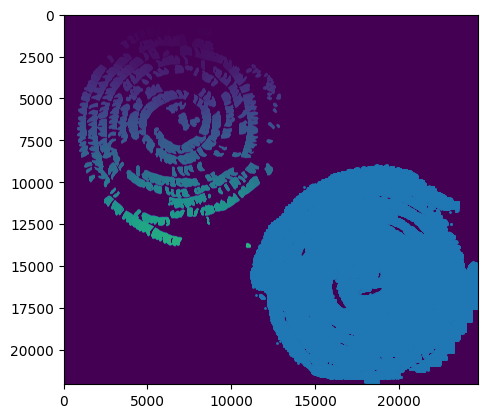

In [69]:


downsize_factor = np.load(os.path.join(merscope_path, 'villi_segmentation_downsize_factor.npy')) 

xvals = np.array(transformed_points)[:, 0]/downsize_factor
yvals = np.array(transformed_points)[:, 1]/downsize_factor

plt.imshow(vill_seg)
plt.scatter(xvals, yvals, s=1)
plt.show()

villi_numbers = vill_seg[yvals.astype(int), xvals.astype(int)]
adata.obs['villi_number'] = villi_numbers

In [71]:
in_villi = []
for i in adata.obs['villi_number'].values:
    if i == 0:
        in_villi.append(False)
    else:
        in_villi.append(True)

adata.obs['in_villi'] = in_villi
unique_villi = np.unique(adata.obs.villi_number)

Calculating the the training crypt-villus axis for the reference dataset

In [80]:
adata.obs = adata.obs.merge(reference_unrolled.obs[['normalized_crypt_villi']], how='left', left_index=True, right_index=True)

In [81]:
norm_scaled = np.zeros(len(adata.obs.index.values))
for i in tqdm(unique_villi):
    if i == 0:
        indices = np.array(adata.obs['villi_number'] == i)
        norm_vals = adata[indices, :].obs['normalized_crypt_villi'].values
        norm_scaled[indices] = norm_vals
    else:
        indices = np.array(adata.obs['villi_number'] == i)
        norm_vals = adata[indices, :].obs['normalized_crypt_villi'].values
        norm_scaled[indices] = norm_vals/np.max(norm_vals)

  0%|          | 0/583 [00:00<?, ?it/s]

In [82]:
adata.obs['normalized_crypt_villi_scaled'] = norm_scaled

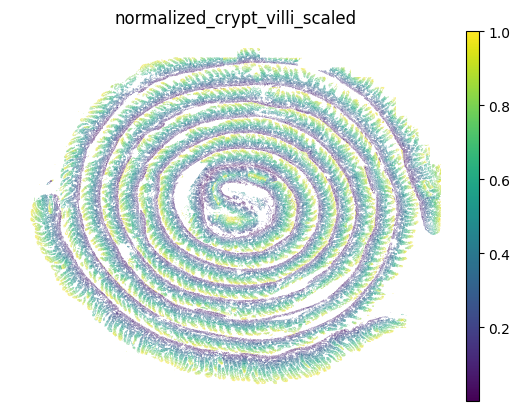

In [83]:
sc.pl.embedding(adata, basis='spatial', color='normalized_crypt_villi_scaled', frameon=False)

In [84]:
adata.write(os.path.join(merscope_path, 'adatas', '07_axes_defined_reference_roll1.h5ad'))